# Kagome AntiferroMagnet

Date: 21 January,2024,Sunny#main

The goal is to calculate linear spinwave spectrum for the Kagome antiferromagnet using incommensurate spiral structure.

Load Packages.


In [5]:
using Sunny,CairoMakie, LinearAlgebra,Optim, Revise
includet("DispersionandIntensitiesDipoleSingleQ.jl")
includet("SWTSingleQcalculations.jl")

Build a crystal

In [6]:
a = 6
b = 6
c = 40
latvecs = lattice_vectors(a,b,c,90,90,120)
positions = [[0.5,0,0]]
types = ["A"]
cryst = Crystal(latvecs,positions,147;types)

Crystal
Spacegroup 'P -3' (147)
Lattice params a=6, b=6, c=40, α=90°, β=90°, γ=120°
Cell volume 1247
Type 'A':
   1. [1/2, 0, 0]
   2. [0, 1/2, 0]
   3. [1/2, 1/2, 0]


Build a System with antiferrogmanetic nearest neighbor exchange J = 1

In [7]:
bond1 = Bond(2,3,[0,0,0])
J1 = 1.
sys = System(cryst,(1,1,1),[SpinInfo(1,S=1,g=1)], :dipole,seed =0)
set_exchange!(sys,[J1 0 0;0 J1 0;0 0 J1],bond1)

Axis of rotation, n = [0.0,0.0,1], along c -direction.


In [8]:
n = [0.0,0.0,1];

We can also check whether the interaction of system is invariant under axis of rotation using check_rotational_symmetry function.

In [9]:
Sunny.check_rotational_symmetry(sys; n, θ=0.01)

Now we need to find the magnetic ground state. optimagstr function helps us to find the ground state and the propagation vector for that ground state.It uses a constraint function (gm_planar in this case) to reduce the number of paramteres that has to be optimised. It works well if the number of free parameters are low. we will find that the right k-vector is [1/3,1/3,0].

In [10]:
randomize_spins!(sys)
#       Phi1   Phi2  Phi3  k_x  k_y   k_z
xmin = [-1e-6 -1e-6 -1e-6 -1e-6 -1e-6 -1e-6] # Maximum value of x
xmax = [2π 2π 2π 1 1 1e-6]   # Minimum value of x
x0 = [0.2 0.2 0.2 0.3 0.3 0.0]  # initial value of x
k = optimagstr(x ->gm_planar!(sys,n,x),xmin,xmax,x0)

Ground state Energy(meV) = -3.0000000000000004


3-element Vector{Float64}:
  0.3333333338512749
  0.33333333344255667
 -8.629308608581729e-12

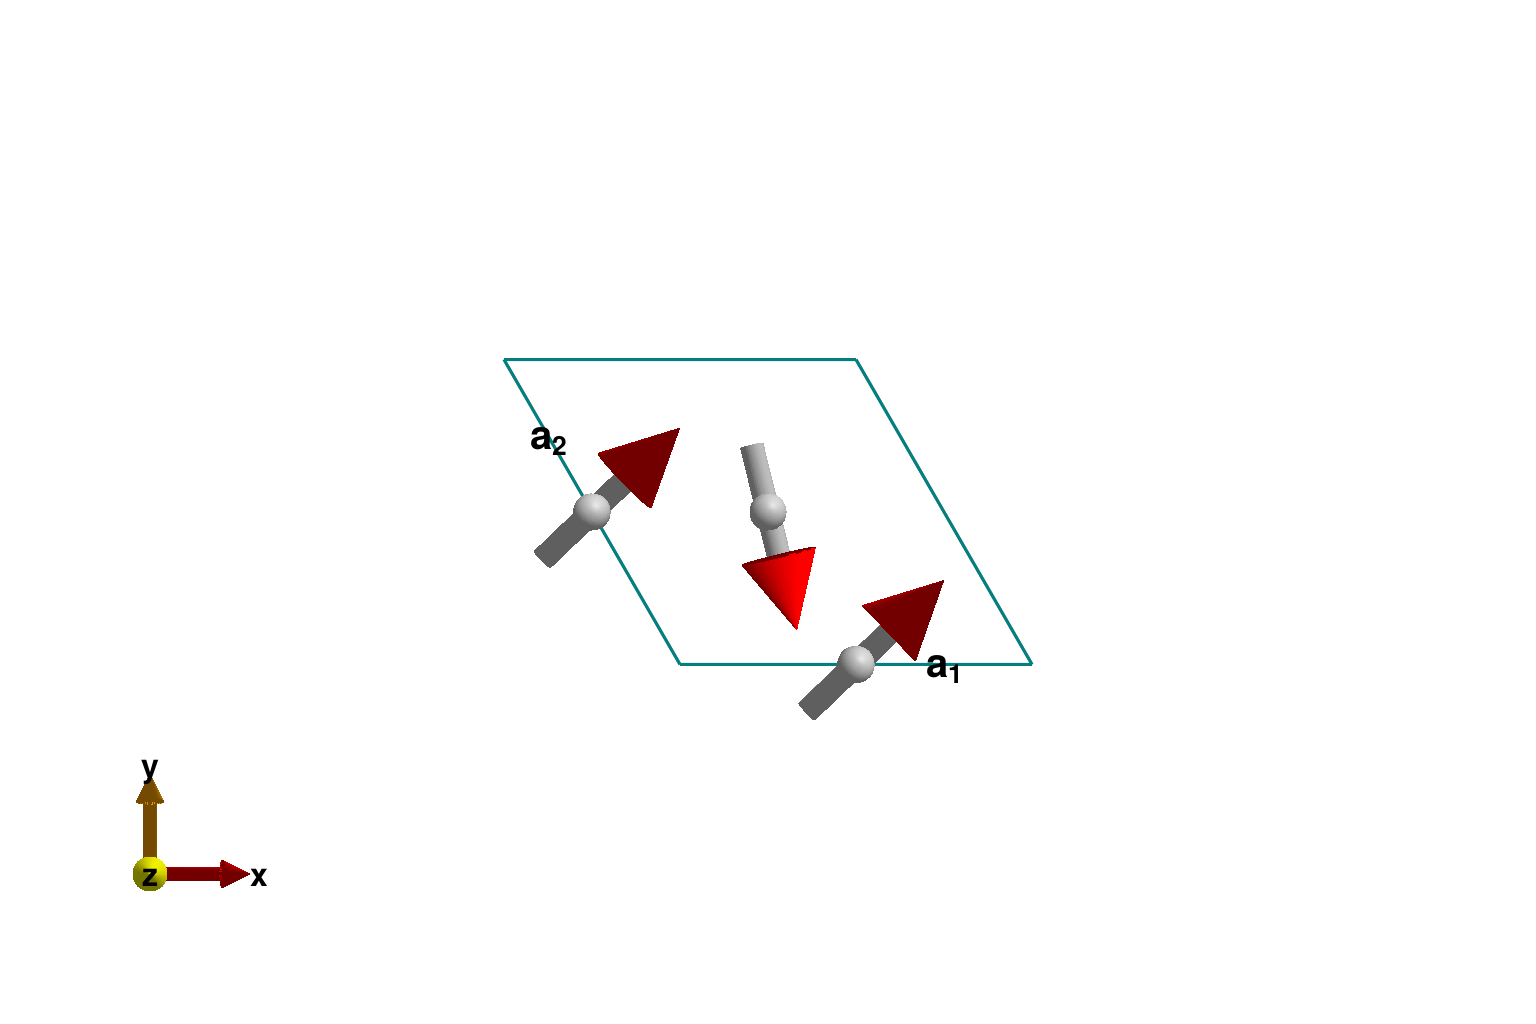

In [11]:
plot_spins(sys;dims=2)

Define a path in reciprocal space.

In [12]:
qs = [[-0.5,0,0.],[0.0,0.,0],[0.5,0.5,0]]
density = 250
path, xticks = reciprocal_space_path(cryst, qs, density);

Calculating dispersion and intensities.

In [13]:
swt = SpinWaveTheory(sys)
formula = intensity_formula_SingleQ(swt,k,n, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands_SingleQ(swt, path, formula);

Here, the dimension of both disp and intensities are [414×9], where 414 represents path and 9 includes 3 sites plus 3 modes (k+Q,K and K-Q) of incommensurate spin structure.

Plotting dispersion and Intensities.

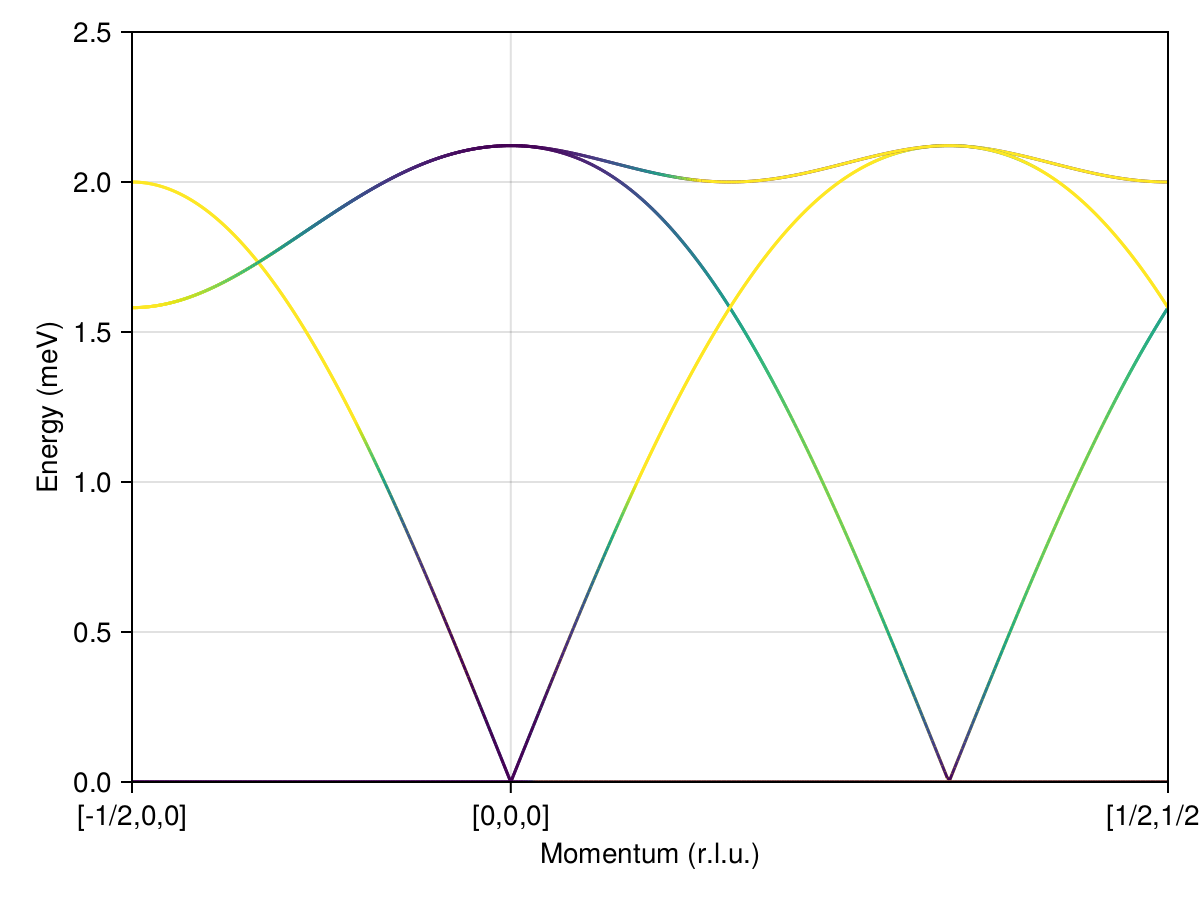

In [14]:
CairoMakie.activate!
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks)
ylims!(ax, 0, 2.5)
xlims!(ax, 1, size(disp, 1))
for i in axes(disp, 2)
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color=intensity[:,i],colorrange=(0,0.03))
end
fig

Calculate Intensities

In [15]:

γ = 0.02 # width in meV
broadened_formula = intensity_formula_SingleQ(swt,k,n, :perp; kernel=lorentzian(γ),formfactors=nothing)
energies = collect(0:0.005:3)  # 0 < ω < 10 (meV).
is = intensities_broadened_SingleQ(swt, path, energies, broadened_formula);

 The calculated intensity is a tensor with dimension [path×energies×nmodes×branch]. 
 Here,branch corresponds to K,K+Q and K-Q modes of incommensurate spin structure. 

 Plotting of intensities using CairoMakie.

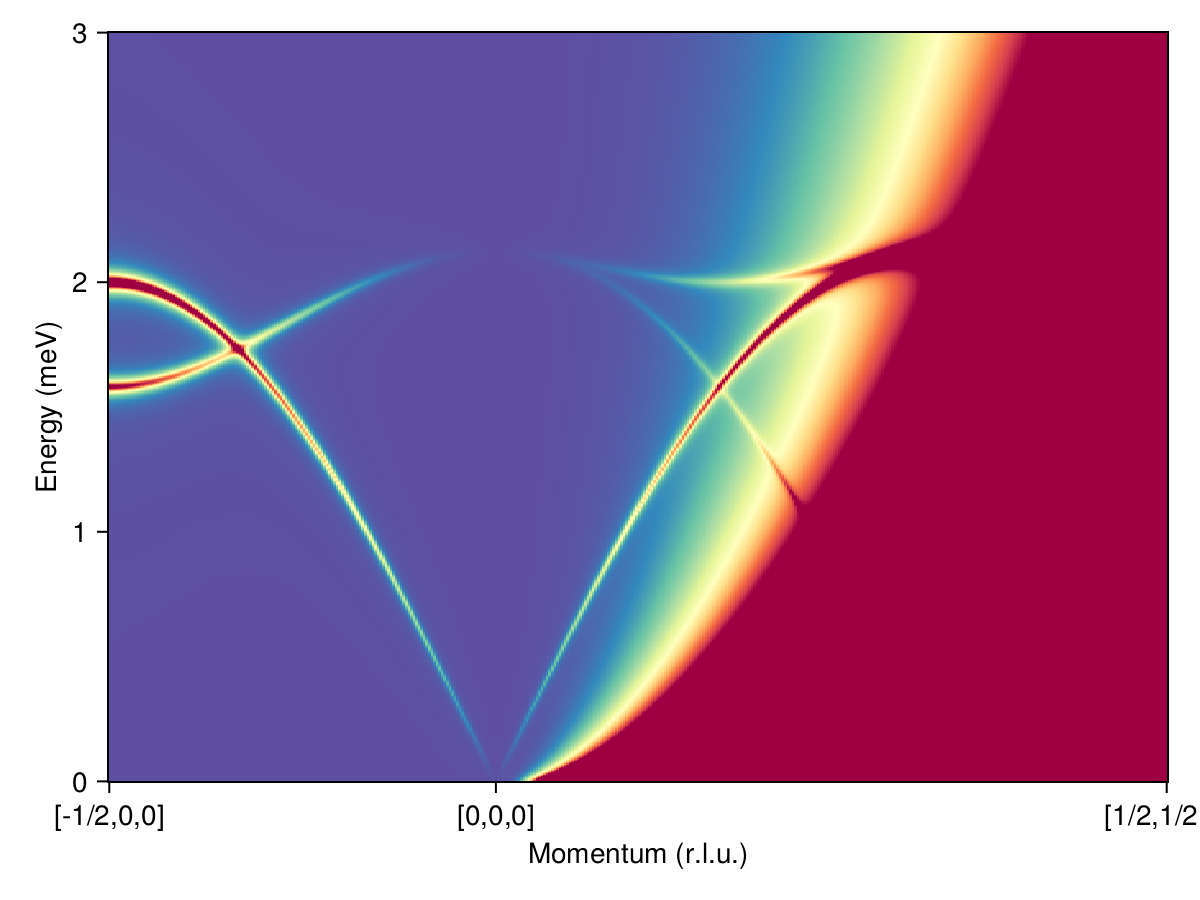

In [16]:
begin
    CairoMakie.activate!()
    fig = Figure() 
    ax = Axis(fig[1,1];xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks, xticklabelrotation=0)
    pl = heatmap!(ax,1:size(is, 1),energies,dropdims(sum(is[:,:,1:3,1:3],dims=[3,4]),dims=(3,4)))
    pl.colormap = Reverse(:Spectral)
    pl.colorrange = (0,3)
    fig
end

Plotting the intensity by neglecting the zero energy mode

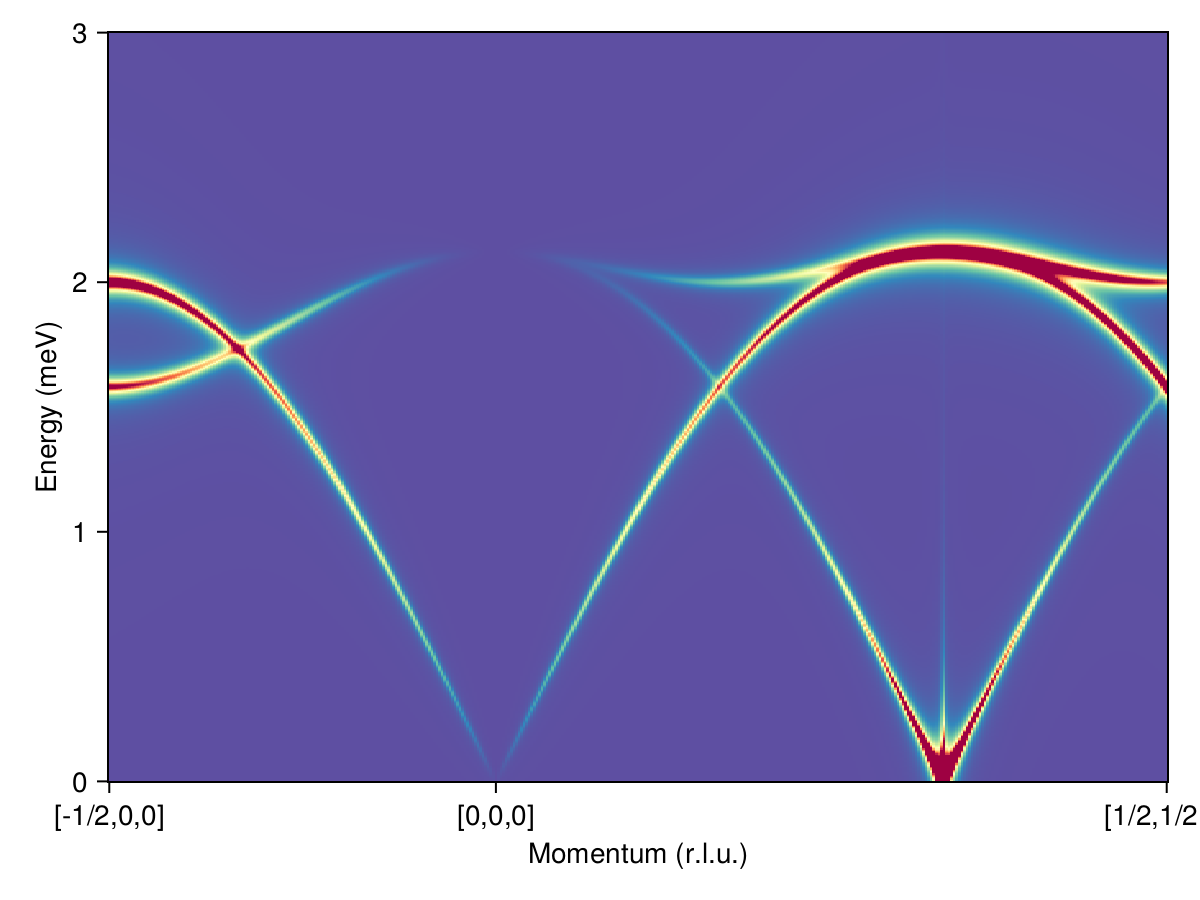

In [17]:
begin
    CairoMakie.activate!()
    fig = Figure() 
    ax = Axis(fig[1,1];xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", xticks, xticklabelrotation=0)
    pl = heatmap!(ax,1:size(is, 1),energies,dropdims(sum(is[:,:,1:2,1:3],dims=[3,4]),dims=(3,4)))
    pl.colormap = Reverse(:Spectral)
    pl.colorrange = (0,3)
    fig
end